In [1]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs/src/master/

Cloning into 'master'...
remote: Counting objects: 6, done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 6 (delta 0), reused 0 (delta 0)
Unpacking objects: 100% (6/6), done.


In [2]:
!ls master

#first file contains names with labels
#the rest are the data (pickle files)

signnames.csv  test.p  train.p	valid.p


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
import pickle
import pandas as pd
import random

In [4]:
np.random.seed(0)

In [5]:
# with is used whenever you want to execute two operations as a pair  and they have an invoke block of code in between
# in our case we want it to open and close a file
with open('master/train.p', 'rb') as f: # rb = read binary
  train_data = pickle.load(f)
with open('master/valid.p', 'rb') as f: # rb = read binary
  val_data = pickle.load(f)
with open('master/test.p', 'rb') as f: # rb = read binary
  test_data = pickle.load(f)

print(type(train_data)) # notice that it is a dictionary with the following pairs:

X_train, y_train = train_data['features'], train_data['labels']
X_val, y_val = val_data['features'], val_data['labels']
X_test, y_test = test_data['features'], test_data['labels']

<class 'dict'>


In [6]:
print(X_train.shape) # notice that the depth is 3 because traffic sign are RGB images
print(X_val.shape)
print(X_test.shape)

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


In [7]:
assert(X_train.shape[0] == y_train.shape[0]), "The number of images is not equal to the number of labels"
assert(X_val.shape[0] == y_val.shape[0]), "The number of images is not equal to the number of labels"
assert(X_test.shape[0] == y_test.shape[0]), "The number of images is not equal to the number of labels"
assert(X_train.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3"
assert(X_val.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3"
assert(X_test.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3"

In [8]:
data = pd.read_csv('master/signnames.csv')
print(data)

    ClassId                                           SignName
0         0                               Speed limit (20km/h)
1         1                               Speed limit (30km/h)
2         2                               Speed limit (50km/h)
3         3                               Speed limit (60km/h)
4         4                               Speed limit (70km/h)
5         5                               Speed limit (80km/h)
6         6                        End of speed limit (80km/h)
7         7                              Speed limit (100km/h)
8         8                              Speed limit (120km/h)
9         9                                         No passing
10       10       No passing for vechiles over 3.5 metric tons
11       11              Right-of-way at the next intersection
12       12                                      Priority road
13       13                                              Yield
14       14                                            

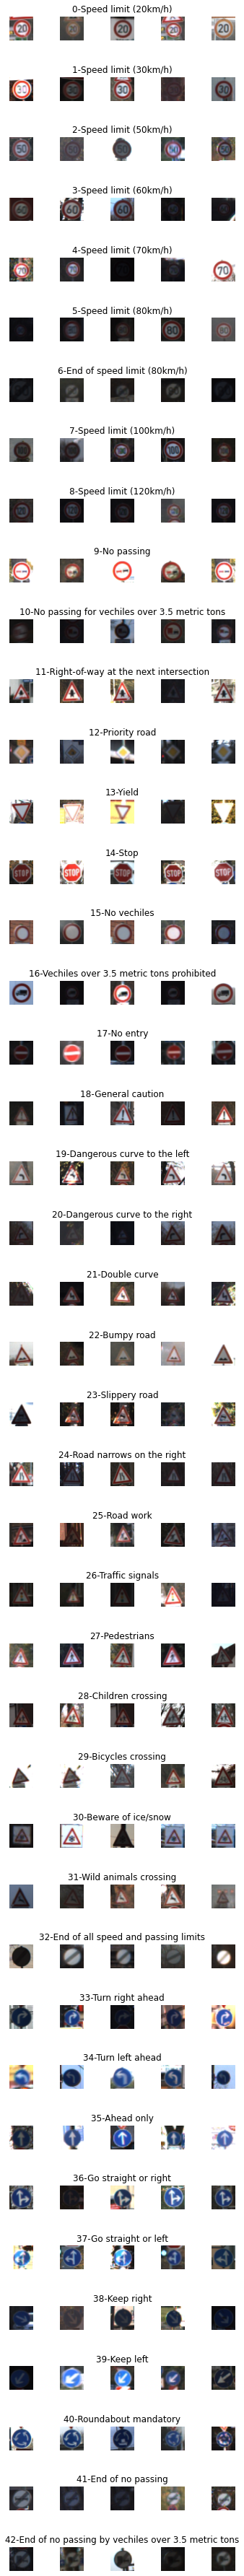

In [9]:
num_of_samples = []
 
cols = 5
num_classes = 43
 
fig, axs = plt.subplots(nrows=num_classes, ncols = cols, figsize=(5, 50))
fig.tight_layout()
for i in range(cols):
    #for j in range(num_classes):
    for j, row in data.iterrows(): # now we itterate over our entire data frame rows as index and series pairs (index, Series)
    # the Series holds all the data relevant to the row (row no. indicated by the index) and we use place holder "row" to itterate through the series 
        x_selected = X_train[y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0, len(x_selected - 1)), :, :], cmap=plt.get_cmap("gray"))
        axs[j][i].axis("off")
        if i == 2:
            axs[j][i].set_title(str(j) + "-" + row["SignName"])
            num_of_samples.append(len(x_selected))


[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


Text(0, 0.5, 'Number of images')

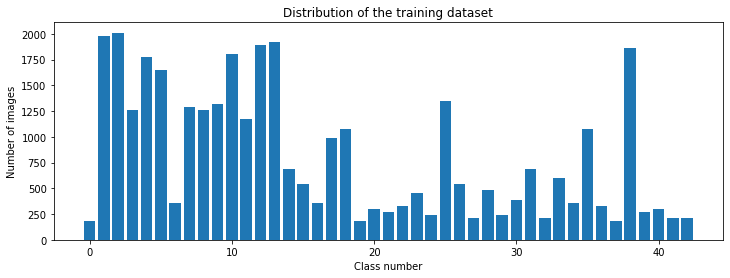

In [10]:
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the training dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")

(32, 32, 3)
36


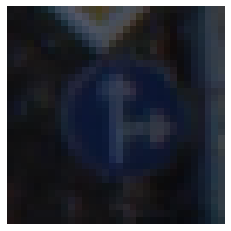

In [11]:
import cv2

plt.imshow(X_train[1000]) # plotting a random image in our data set 
plt.axis("off")
print(X_train[1000].shape) # to keep track of how it changes through processing
print(y_train[1000]) # just to make sure it has the right label

(32, 32)


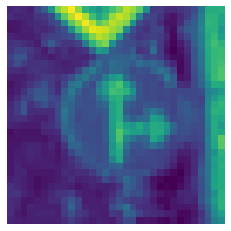

In [12]:
# now we move to our first pre-processing technique : (RGB to grayscale)

def grayscale(img):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  return img

img = grayscale(X_train[1000])
plt.imshow(img) 
plt.axis("off")
print(img.shape)
# don't know why it is not grayscale !

(32, 32)


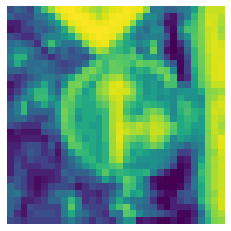

In [13]:
# next pre processing tech. is histogram equalization
#  it aims to standarize the lighting in all our images

def equalize(img):
  img = cv2.equalizeHist(img) #imp: this function only accepts gray scale images with no depth
  return img

img = equalize(img)
plt.imshow(img) 
plt.axis("off")
print(img.shape)

In [14]:
# now we need to apply all these techniques to all our images 

def preprocessing(img):
  img = grayscale(img)
  img = equalize(img)
  img = img/255
  return img

X_train = np.array(list(map(preprocessing, X_train)))
X_val = np.array(list(map(preprocessing, X_val)))
X_test = np.array(list(map(preprocessing, X_test)))

(32, 32)


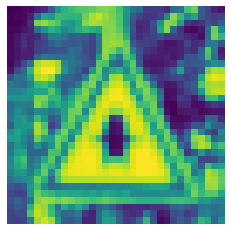

In [15]:
plt.imshow(X_train[random.randint(0,len(X_train - 1))]) 
plt.axis("off")
print(img.shape)

In [16]:
# next step is to add depth to our data 
X_train = X_train.reshape(34799, 32, 32, 1)
X_val = X_val.reshape(4410, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)

In [17]:
########################################################
# DATA AUGMENTATION
########################################################

from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(width_shift_range=0.1, # which means maximum shift is fraction 10% of the image, # if we enter a value higher than one then the unit is pixels ( =10 means max shift of 10 pixels)  
                            height_shift_range=0.1, # same but vertical
                            zoom_range=0.2, # zoom out to max. 0.8 and zoom in to max. 1.2
                            shear_range=0.1 , # see mobile photo
                            rotation_range=10) # degrees

datagen.fit(X_train) # this data generator does not perform operations on all the data because this will be memory intensive, instead it only creates these new augmented images when requested 
 

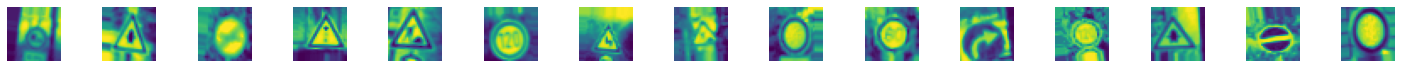

In [18]:
########################################################
# DATA AUGMENTATION
########################################################


batches = datagen.flow(X_train, y_train, batch_size=20)
X_batch, y_batch = next(batches) # we get 20 new images each time the function is called on the itterator

fig, axs = plt.subplots(1, 15, figsize=(20,5))
fig.tight_layout()

for i in range(15):
  axs[i].imshow(X_batch[i].reshape(32,32))
  axs[i].axis('off')

# now to integrate this with our model we modify model.fit statement 

In [19]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(34799, 32, 32, 1)
(4410, 32, 32, 1)
(12630, 32, 32, 1)


In [20]:
# Last step for preprocessing is to hot_code our labels 

y_train = to_categorical(y_train, 43)
y_val = to_categorical(y_val, 43)
y_test = to_categorical(y_test, 43)

In [21]:
# designing our neural network

def modified_model():
  model = Sequential()
  model.add(Conv2D(60, (5,5), input_shape=(32,32,1), activation='relu'))
  model.add(Conv2D(60, (5,5), activation='relu')) # new layer
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Conv2D(30, (3,3), activation='relu'))
  model.add(Conv2D(30, (3,3), activation='relu')) # new layer
  model.add(MaxPooling2D(pool_size=(2,2)))
  #model.add(Dropout(0.5)) # removed because we no longer have overfitting problem 
  model.add(Flatten())
  model.add(Dense(500, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation='softmax'))
  model.compile(Adam(lr=0.01), loss='categorical_crossentropy', metrics= ['accuracy'])
  return model

In [22]:
model = modified_model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 60)        1560      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 60)        90060     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 60)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 30)        16230     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 30)          8130      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 30)          0         
_________________________________________________________________
flatten (Flatten)            (None, 480)               0

In [ ]:
###############################################################################
# Because of DATA AUGMENTATION we used the method fit_generator instead of fit
###############################################################################

history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=50), steps_per_epoch=2000, epochs=10, validation_data = (X_val, y_val), shuffle=1 ) # batch_size=50 means it will generate 50 images each time for us to use # 2000 per batch * 50 batches we get 100000 per epoch

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('epoch')

In [ ]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test Score: ', score[0])
print('Test Accuracy: ', score[1])

In [ ]:
# now we will put our model in a real test by evaluating real images from the internet

In [ ]:
#fetch images from web
 
import requests
from PIL import Image
# 1st image : right prediction
# url = 'https://c8.alamy.com/comp/G667W0/road-sign-speed-limit-30-kmh-zone-passau-bavaria-germany-G667W0.jpg'

# 2nd image : wrong prediction
url = 'https://c8.alamy.com/comp/A0RX23/cars-and-automobiles-must-turn-left-ahead-sign-A0RX23.jpg'

# 3rd image : right prediction
# url = 'https://previews.123rf.com/images/bwylezich/bwylezich1608/bwylezich160800375/64914157-german-road-sign-slippery-road.jpg'

# 4th image : right prediction
# url = 'https://previews.123rf.com/images/pejo/pejo0907/pejo090700003/5155701-german-traffic-sign-no-205-give-way.jpg'

# 5th image : right prediction
# url = 'https://c8.alamy.com/comp/J2MRAJ/german-road-sign-bicycles-crossing-J2MRAJ.jpg'

r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))

In [ ]:
#Preprocess image
 
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocessing(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)

In [ ]:
#Reshape reshape
 
img = img.reshape(1, 32, 32, 1)
 


In [ ]:
#Test image
print("predicted sign: "+ str(model.predict_classes(img)))

In [ ]:
# as we can see ur model failed only 1/5 predictions ! which means our is pretty accurate!